# Week 5: Gradient Boosted Trees и SVM

Цель: изучить теорию и практику обучения моделей Gradient Boosted Trees (XGBoost/LightGBM/CatBoost) и SVM (linear и kernel), а также сравнить их производительность с Random Forest.

## Лабораторная работа - Фролова А.И.
Цель: закрепить навыки работы с Gradient Boosted Trees и SVM, а также их сравнение с Random Forest.

1) Подготовка данных (10%)
- Загрузите или сгенерируйте собственный 2D набор для бинарной классификации (например, `make_circles` или реальный датасет). Разделите на train/test. Опишите кратко данные.


Форма данных: X_train (700, 2), X_test (300, 2)
Баланс классов: (array([0, 1]), array([500, 500]))
Данные: два круга с шумом



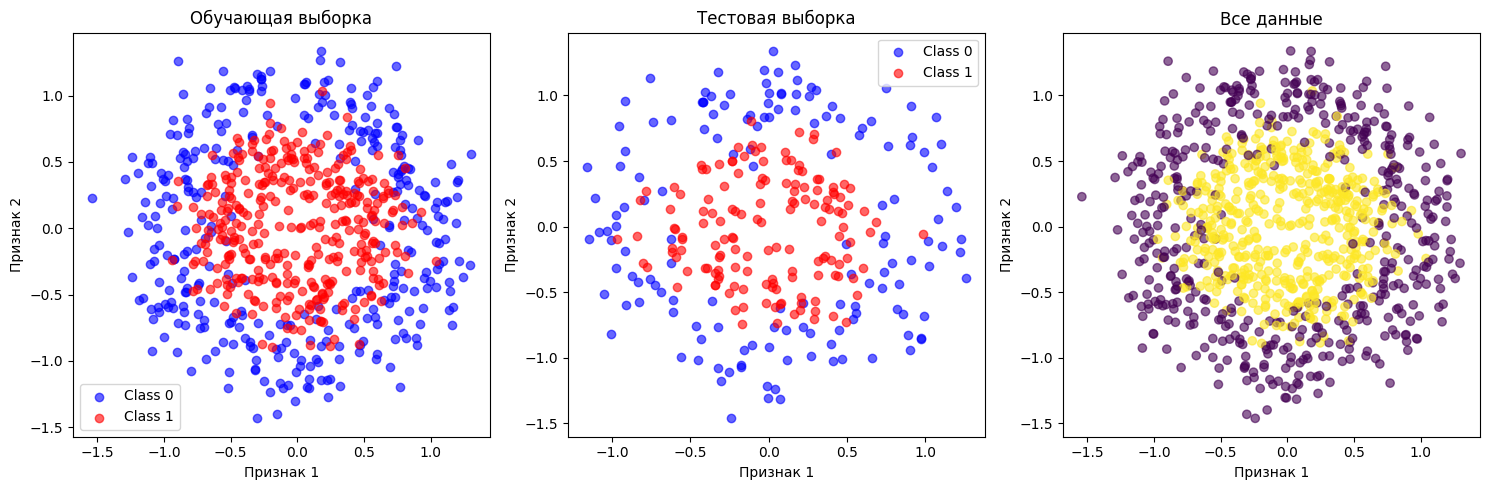

In [43]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Фиксация случайных состояний для воспроизводимости
SEED = 42
np.random.seed(SEED)

# Генерация синтетического набора данных
X, y = make_circles(n_samples=1000, noise=0.2, factor=0.5, random_state=SEED)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

print(f"Форма данных: X_train {X_train.shape}, X_test {X_test.shape}") # (кол-во объектов, кол-во признаков)
print(f"Баланс классов: {np.unique(y, return_counts=True)}") # 50/50 у меня
print(f"Данные: два круга с шумом\n")

# Визуализация данных
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', alpha=0.6, label='Class 0')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', alpha=0.6, label='Class 1')
plt.title('Обучающая выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='blue', alpha=0.6, label='Class 0')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='red', alpha=0.6, label='Class 1')
plt.title('Тестовая выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title('Все данные')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

plt.tight_layout()
plt.show()



2) Gradient Boosted Trees (30%)
- Обучите две модели из семейства boosting (например, XGBoost и LightGBM или их аналог из sklearn). Подберите базовые гиперпараметры (n_estimators, learning_rate, max_depth). Сравните Accuracy и ROC AUC. Кратко интерпретируйте результат.

Accuracy - сколько правильных ответов дала модель;

ROC AUC - способность модели разделять классы.

В лабе использовалось два Gradient Boosted с разными параметрами.

In [44]:
# Масштабирование StandardScaler для SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение Gradient Boosting моделей
# subsample - подвыборка
gb_models = {
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED
    ),
    'GradientBoosting_tuned': GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=SEED
    )
}

gb_results = []

# обучение gradient boosting
for name, model in gb_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    gb_results.append((name, acc, auc))

    print(f"{name}: Accuracy = {acc:.4f}, ROC AUC = {auc:.4f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(gb_results, columns=['Model', 'Accuracy', 'ROC_AUC'])
print("\nРезультаты Gradient Boosting:")
print(results_df)


GradientBoosting: Accuracy = 0.8867, ROC AUC = 0.9520
GradientBoosting_tuned: Accuracy = 0.8833, ROC AUC = 0.9468

Результаты Gradient Boosting:
                    Model  Accuracy   ROC_AUC
0        GradientBoosting  0.886667  0.952000
1  GradientBoosting_tuned  0.883333  0.946844


3) SVM: linear и kernel (30%)
- Обучите LinearSVC и SVC(RBF) на ваших данных. Исследуйте влияние гиперпараметров C и gamma (для RBF) с помощью краткого grid search или нескольких ручных запусков. Сравните с boosting и Random Forest.


In [45]:
svm_models = {
    'LinearSVC': LinearSVC(C=1.0, random_state=SEED),
    'SVC_RBF': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=SEED)
}

svm_results = []
print("Обучение SVM моделей...")

for name, model in svm_models.items():
    # SVM требует масштабирования признаков
    model.fit(X_train_scaled, y_train)

    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Для LinearSVC используем decision_function
        decision_scores = model.decision_function(X_test_scaled)
        y_proba = 1 / (1 + np.exp(-decision_scores))

    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    svm_results.append((name, acc, auc))

    print(f"{name}: Accuracy = {acc:.4f}, ROC AUC = {auc:.4f}")

# Добавляем SVM результаты в общую таблицу
svm_results_df = pd.DataFrame(svm_results, columns=['Model', 'Accuracy', 'ROC_AUC'])
results_df = pd.concat([results_df, svm_results_df], ignore_index=True)


Обучение SVM моделей...
LinearSVC: Accuracy = 0.4800, ROC AUC = 0.4692
SVC_RBF: Accuracy = 0.8967, ROC AUC = 0.9644


RandomForest: Accuracy = 0.8833, ROC AUC = 0.9447
                 Model  Accuracy  ROC_AUC
               SVC_RBF  0.896667 0.964444
      GradientBoosting  0.886667 0.952000
GradientBoosting_tuned  0.883333 0.946844
          RandomForest  0.883333 0.944711
             LinearSVC  0.480000 0.469200


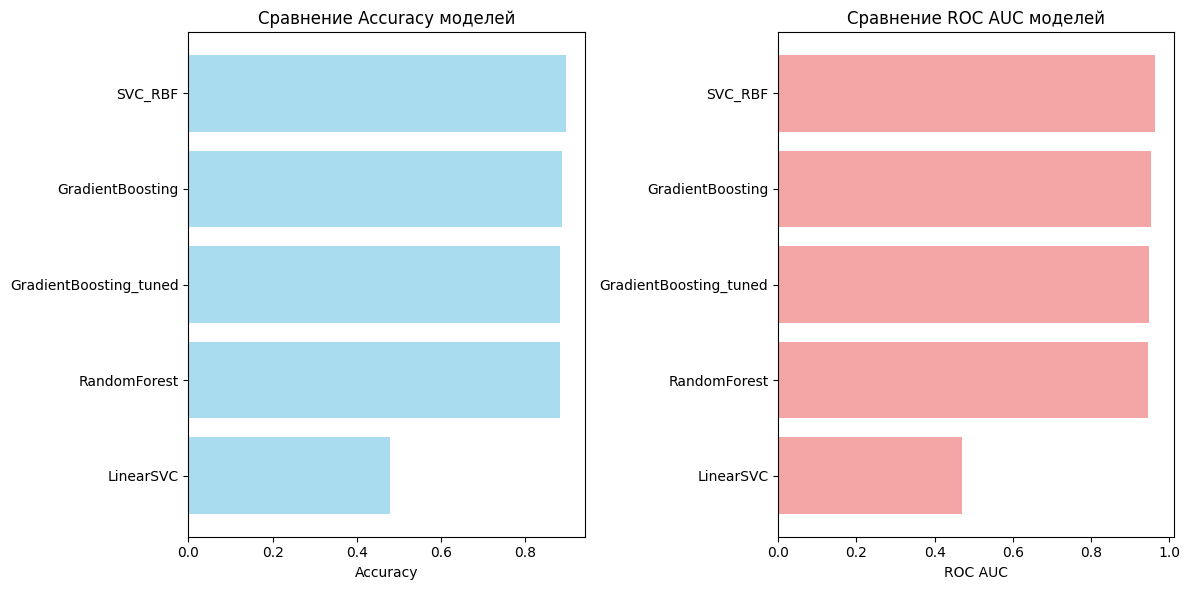

In [46]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

rf_result = pd.DataFrame([('RandomForest', acc_rf, auc_rf)],
                        columns=['Model', 'Accuracy', 'ROC_AUC'])
results_df = pd.concat([results_df, rf_result], ignore_index=True)

print(f"RandomForest: Accuracy = {acc_rf:.4f}, ROC AUC = {auc_rf:.4f}")

# Сортируем по ROC AUC
results_df = results_df.sort_values('ROC_AUC', ascending=False)
print(results_df.to_string(index=False))

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(results_df['Model'], results_df['Accuracy'], color='skyblue', alpha=0.7)
plt.xlabel('Accuracy')
plt.title('Сравнение Accuracy моделей')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(results_df['Model'], results_df['ROC_AUC'], color='lightcoral', alpha=0.7)
plt.xlabel('ROC AUC')
plt.title('Сравнение ROC AUC моделей')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


4) Визуализация границ решений (20%)
- Постройте визуализацию границы решений для лучших по ROC AUC моделей в каждой группе: один boosting, один SVM. Используйте Plotly; убедитесь, что на графике видны точки train/test (разными символами/цветами).


Лучшая Gradient Boosting модель: GradientBoosting
Лучшая SVM модель: SVC_RBF

Визуализация границы для GradientBoosting:


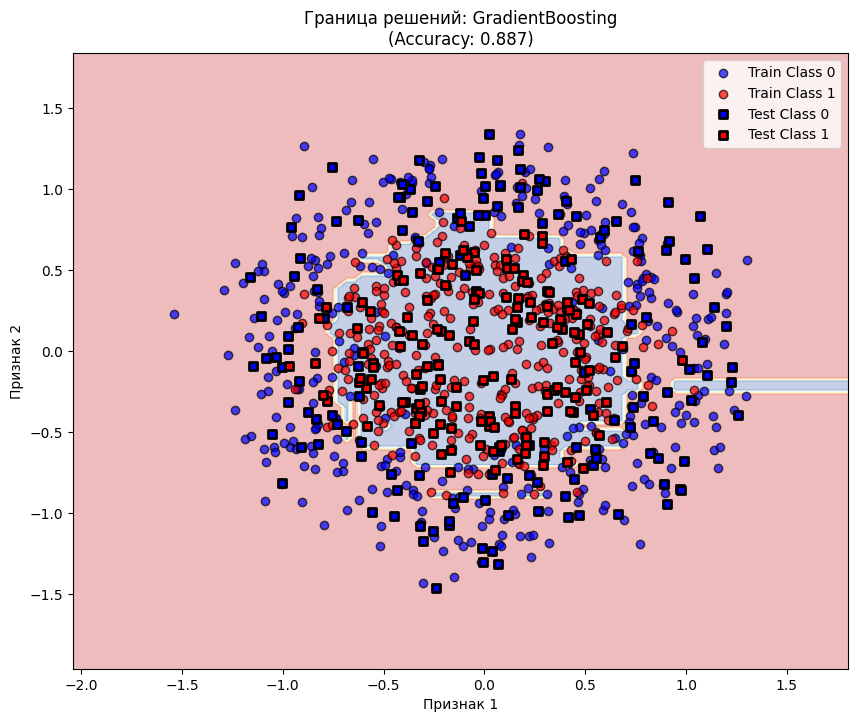


Визуализация границы для SVC_RBF:


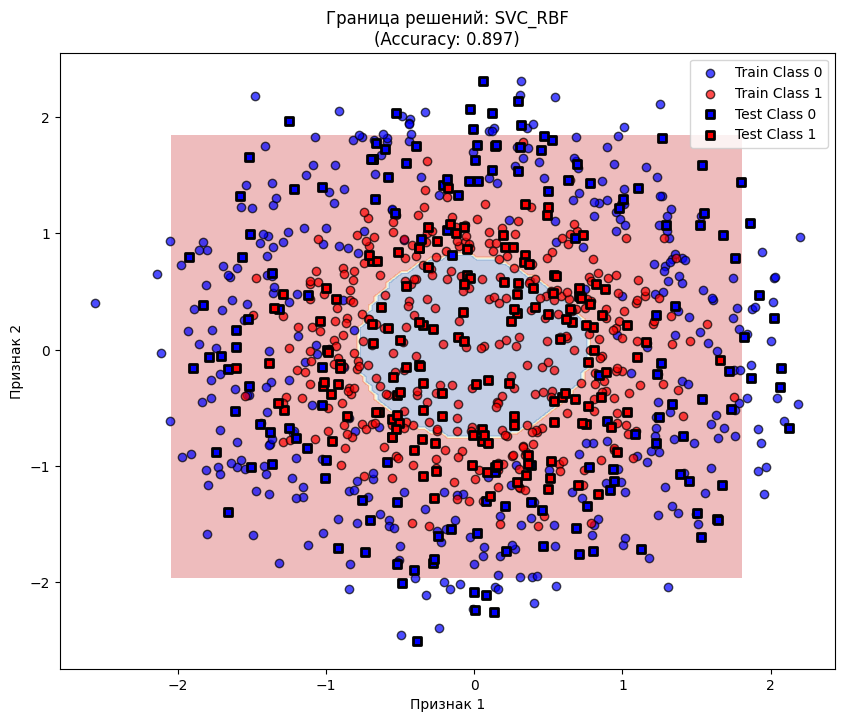

In [47]:
# Выбираем лучшие модели из каждой группы
best_gb_model_name = results_df[results_df['Model'].str.contains('Gradient')].iloc[0]['Model']
best_svm_model_name = results_df[results_df['Model'].str.contains('SVC')].iloc[0]['Model']

print(f"Лучшая Gradient Boosting модель: {best_gb_model_name}")
print(f"Лучшая SVM модель: {best_svm_model_name}")

# Создаем сетку для визуализации
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Функция для визуализации границы решений
def plot_decision_boundary(model, X_train, y_train, X_test, y_test, title, is_svm=False):
    plt.figure(figsize=(10, 8))

    # Предсказания на сетке
    if is_svm:
        grid_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
        Z = model.predict(grid_scaled)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    # Визуализация границы решения
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

    # Тренировочные точки
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                c='blue', marker='o', alpha=0.7, label='Train Class 0', edgecolors='black')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                c='red', marker='o', alpha=0.7, label='Train Class 1', edgecolors='black')

    # Тестовые точки
    plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
                c='blue', marker='s', alpha=1.0, label='Test Class 0', edgecolors='black', linewidth=2)
    plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
                c='red', marker='s', alpha=1.0, label='Test Class 1', edgecolors='black', linewidth=2)

    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title(f'{title}\n(Accuracy: {accuracy_score(y_test, model.predict(X_test if not is_svm else X_test_scaled)):.3f})')
    plt.legend()
    plt.show()

# Визуализация для лучшей Gradient Boosting модели
best_gb_model = gb_models[best_gb_model_name]
print(f"\nВизуализация границы для {best_gb_model_name}:")
plot_decision_boundary(best_gb_model, X_train, y_train, X_test, y_test,
                      f'Граница решений: {best_gb_model_name}', is_svm=False)

# Визуализация для лучшей SVM модели
best_svm_model = svm_models[best_svm_model_name]
print(f"\nВизуализация границы для {best_svm_model_name}:")
plot_decision_boundary(best_svm_model, X_train_scaled, y_train, X_test_scaled, y_test,
                      f'Граница решений: {best_svm_model_name}', is_svm=True)


5) Аналитика и выводы (10%)
- Сформулируйте, когда на вашем типе данных SVM выигрывает/проигрывает boosting и наоборот. Укажите, какие гиперпараметры оказались наиболее критичны.

- SVC linear проигрывает другим моделям, так как данные нелинейны, и ее использование просто нецелесообразно;
- В данном случае SVC RBF дает лучший результат, позволяя корректнее разделить данные;
________________________________________________________

- Boosting будет выигрывать в том случае, если нужен баланс между качеством и скоростью и не хочется масштабировать данные;
- SVC - когда данные сложные, и необходима большая точность.
________________________________________________________
- Параметры для Boosting - learning_rate, max_depth
- Параметры для SVC RBF - gamma, C.

## Чек-лист: типичные ошибки и анти‑паттерны

- Отсутствие масштабирования для SVM: `StandardScaler` обязателен для стабильной настройки `C` и `gamma`.
- Сравнение моделей на разных разбиениях: используйте одинаковый `train_test_split` или кросс-валидацию.
- Неправильная интерпретация ROC AUC при дисбалансе: при сильном дисбалансе смотрите PR AUC и изменяйте порог.
- Переобучение Boosting при большом `learning_rate`: снижайте `learning_rate`, повышайте `n_estimators`, используйте early stopping.
- Игнорирование стохастики: фиксируйте `random_state/SEED` для воспроизводимости, используйте `subsample/colsample` с умом.
- Сравнение метрик без уверенности в пороге: оценивайте кривые (ROC/PR), подбирайте порог по бизнес-критериям.
- Неверная трактовка feature importance: помните, что важности деревьев — относительные; проверяйте устойчивость на различных разбиениях.